In [7]:
!nvidia-smi

Mon Nov 19 09:57:12 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 30%   45C    P2    56W / 250W |   4506MiB / 11171MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 30%   42C    P8    17W / 250W |     10MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [5]:
!kill 2311

In [9]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

[Pre-Processing in Natural Language Machine Learning](https://towardsdatascience.com/pre-processing-in-natural-language-machine-learning-898a84b8bd47)

[Correcting Words using Python and NLTK](https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html)

What You Need to Do:

The assignment will implement a module to perform sentiment analysis of incoming microblogs streams. It should incorporate the following functions:

1. Basic Sentiment Classifier:
    - It will process the training dataset to train the classifiers using any suitable machine learning technique.
    - The initial classifier will be trained based on text features only using a basic set of sentiment lexicon.
    - The basic classifier will assign a new input tweet into 3 classes of: positive (+1), negative (-1) and neutral (0).
    - The ability to predict organization (e.g. Apple) given a Tweet
    - The ability to perform sentiment analysis with respect to given organization classes.

2. Enhanced Functions:
    - Able to explore temporal information in determining the sentiment of incoming tweets.
    - Expand to more than 3 sentiment classes (say in 5-point scale)

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import numpy as np
import scipy
from sklearn.naive_bayes import MultinomialNB

In [4]:
train = pd.read_csv('./Train.csv')
test = pd.read_csv('./Test.csv')

## Dropping irrelevant data

In [5]:
train = train[train.Sentiment != 'irrelevant']
test = test[test.Sentiment != 'irrelevant']
print(train.shape, test.shape)
train.head()

(2272, 4) (237, 4)


,Topic,Sentiment,TweetDate,TweetText
0,apple,positive,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the i...
1,apple,positive,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to ...
2,apple,positive,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet wit...
3,apple,positive,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to ...
4,apple,positive,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twi...


In [6]:
train['TweetText'][2]

"Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY"

In [7]:
train['Topic'].value_counts()

apple        855
microsoft    487
google       473
twitter      457
Name: Topic, dtype: int64

In [8]:
train['Sentiment'].value_counts()

neutral     1475
negative     426
positive     371
Name: Sentiment, dtype: int64

# Data processing

- битовые маски для смайликов
- восклицательные знаки

## Manual feature extraction

In [9]:
mask_exclamation_train = train['TweetText'].str.contains('!').values
mask_exclamation_test = test['TweetText'].str.contains('!').values

In [10]:
mask_fun_smile_train = train['TweetText'].apply(lambda tweet: ')' in tweet and '(' not in tweet).values
mask_sad_smile_train = train['TweetText'].apply(lambda tweet: '(' in tweet and ')' not in tweet).values
mask_fun_smile_test = test['TweetText'].apply(lambda tweet: ')' in tweet and '(' not in tweet).values
mask_sad_smile_test = test['TweetText'].apply(lambda tweet: '(' in tweet and ')' not in tweet).values

def get_manual_features(tweet):
    return np.array(['!' in tweet, ')' in tweet and '(' not in tweet, '(' in tweet and ')' not in tweet]).astype('int')

In [11]:
manual_features_train = np.c_[mask_exclamation_train, mask_fun_smile_train, mask_sad_smile_train]
manual_features_test = np.c_[mask_exclamation_test, mask_fun_smile_test, mask_sad_smile_test]

In [12]:
manual_features_train.shape
manual_features_test.shape

(2272, 3)

(237, 3)

## Tweet text preprocessing

In [13]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import pos_tag, pos_tag_sents
from nltk.corpus import sentiwordnet as swn

In [14]:
def process_message(tweet, lower_case = True, stem = True, stop_words = True):
    tweet = tweet.strip()
    if lower_case:
        tweet = tweet.lower()
#     words = word_tokenize(message)
#     message = re.sub(r'\bhttp*\b', r'LINK', message)
#     message = re.sub(r'\.|\,|\-|\?|\!|\:\s|\;\s|&quot;*|&lt;*',' ', message)
#     message = re.sub(r'\s+', ' ', message)
    tweet = re.sub('http\S+\s*', '', tweet)  # remove URLs
    tweet = re.sub('RT|cc', '', tweet)  # remove RT and cc //was off
    tweet = re.sub('#\S+', '', tweet)  # remove hashtags
#     tweet = re.sub('@\S+', '', tweet)  # remove mentions
#     tweet = re.sub("#[\w]*", '', tweet)
#     tweet = re.sub("@[\w]*", '', tweet) #was off

    tweet = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', tweet)  # remove punctuations
    tweet = re.sub(" \d+", ' ', tweet)
#     tweet = re.sub("[^a-zA-Z#]", ' ', tweet) # remove special characters, numbers, punctuations, one more time
    
    tweet = re.sub('\s+', ' ', tweet)  # remove extra whitespace
    
    words = tweet.split()
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

In [15]:
X_tweets_train = train['TweetText'].apply(process_message)
X_tweets_test = test['TweetText'].apply(process_message)

In [16]:
X_tweets_train

0                        appl get swype iphon crack iphon
1                   appl ad carrier support iphon announc
2       hilari youtub video guy duet appl siri pretti ...
3                  rim made easi switch appl iphon see ya
4               realiz reason got twitter ios5 thank appl
5       im current blackberri user littl bit disappoin...
6       strangest thing siri said far sooo glad appl g...
7       great close person event appl tonight regent s...
8       compani experi best custom servic asid zappo appl
9                            appli job appl hope call lol
10      lmao think appl onto someth magic die haha sir...
11      rt philliprowntre regist appl develop here hop...
12                                  wow great deal refurb
13      regist appl develop here hope actual help grea...
14      你好 current learn mandarin upcom trip hong kong...
15      come dark side 📱“gretcheneclark hey appl send ...
16      hey appl send free iphon version publicli cere...
17            

## Getting tokens scores from SentiWordNet

In [17]:
X_words_train = X_tweets_train.apply(word_tokenize)
X_words_test = X_tweets_test.apply(word_tokenize)

In [18]:
X_pos_train = X_words_train.apply(pos_tag)
X_pos_test = X_words_test.apply(pos_tag)

In [19]:
def tokens_pos_to_sentiments(tokens_pos_lst):
    score_lst = []
    for token in tokens_pos_lst:
        newtag=''
        if token[1].startswith('NN'):
            newtag='n'
        elif token[1].startswith('JJ'):
            newtag='a'
        elif token[1].startswith('V'):
            newtag='v'
        elif token[1].startswith('R'):
            newtag='r'
        else:
            newtag=''       
        if newtag != '':    
            synsets = list(swn.senti_synsets(token[0], newtag))
            #Getting average of all possible sentiments, as you requested        
            score = 0
            if len(synsets) > 0:
                for syn in synsets:
                    score += syn.pos_score() - syn.neg_score()
                score_lst.append(score)
    if score_lst == []:
        return 0
    else:
        return np.sum(score_lst)

In [20]:
X_sent_score_train = X_pos_train.apply(tokens_pos_to_sentiments).values[:, np.newaxis]
X_sent_score_test = X_pos_test.apply(tokens_pos_to_sentiments).values[:, np.newaxis]

## Tokenizing of processed tweet text

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score

In [22]:
count_vectorizer = CountVectorizer()

In [23]:
X_tokens_train = count_vectorizer.fit_transform(X_tweets_train)
X_tokens_test = count_vectorizer.transform(X_tweets_test)

In [24]:
X_tokens_train.shape

(2272, 3784)

## Combine all features

In [25]:
X_train = scipy.sparse.hstack((X_tokens_train, manual_features_train))
X_test = scipy.sparse.hstack((X_tokens_test, manual_features_test))

In [26]:
X_train

<2272x3787 sparse matrix of type '<class 'numpy.int64'>'
	with 15178 stored elements in COOrdinate format>

## All features + company_name added to features

In [27]:
# train["Topic"] = train["Topic"].astype(pd.api.types.CategoricalDtype(categories = ["apple", "microsoft","google","twitter"]))
# test["Topic"] = test["Topic"].astype(pd.api.types.CategoricalDtype(categories = ["apple", "microsoft","google","twitter"]))
# test["Topic"] = test["Topic"].astype('category') #py2
hotTrain = pd.get_dummies(train['Topic'], prefix='company')#dummy_na=True
hotTest = pd.get_dummies(test['Topic'], prefix='company')
company_cols = ['company_apple', 'company_twitter', 'company_microsoft', 'company_google']
X_train_with_comp = scipy.sparse.hstack((X_train, hotTrain[company_cols].values))
X_test_with_comp = scipy.sparse.hstack((X_test, hotTest[company_cols].values))
X_train_with_comp

<2272x3791 sparse matrix of type '<class 'numpy.int64'>'
	with 17450 stored elements in COOrdinate format>

# Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

/Users/max/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [40]:
rf_cls_sentiment = RandomForestClassifier(n_estimators=100)

In [41]:
%%time
rf_cls_sentiment.fit(X_sent_score_train, train['Sentiment'])

CPU times: user 191 ms, sys: 3.93 ms, total: 195 ms
Wall time: 194 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
rf_cls_sentiment.score(X_sent_score_train, train['Sentiment'])
rf_cls_sentiment.score(X_sent_score_test, test['Sentiment'])

0.6914612676056338

0.6540084388185654

In [48]:
f1_score(train['Sentiment'], rf_cls_sentiment.predict(X_sent_score_train), average='weighted')
f1_score(test['Sentiment'], rf_cls_sentiment.predict(X_sent_score_test), average='weighted')

0.6235615849546761

0.581642950773208

# Naïve Bayes Model

In [49]:
from sklearn.naive_bayes import MultinomialNB

## Sentiment

In [50]:
%%time
nb_cls_sentiment = MultinomialNB()
nb_cls_sentiment.fit(X_train, train['Sentiment'])

CPU times: user 13.6 ms, sys: 7.61 ms, total: 21.2 ms
Wall time: 37.4 ms


In [51]:
nb_cls_sentiment.score(X_train, train['Sentiment']) # deleted  single numbers, but not like ios5 or iphone10, because its model
nb_cls_sentiment.score(X_test, test['Sentiment'])

0.8789612676056338

0.7510548523206751

In [53]:
f1_score(train['Sentiment'], nb_cls_sentiment.predict(X_train), average='weighted')
f1_score(test['Sentiment'], nb_cls_sentiment.predict(X_test), average='weighted')

0.8728932367605703

0.7309731053879309

In [67]:
def models_api(request_sentiment, classifier):
    processed_request = process_message(request_sentiment)
    print("processed_request:", processed_request)
    vectorized = count_vectorizer.transform([processed_request])
    cls_score = classifier.predict_proba(
        scipy.sparse.hstack(
            (vectorized.toarray(), get_manual_features(request_sentiment))
        )
    )
    return cls_score

### API

In [68]:
request_sentiment = "@apple @siri is efffing amazing!!))"
models_api(request_sentiment, nb_cls_sentiment)

processed_request: appl siri eff amaz


array([[0.00738008, 0.15400853, 0.83861139]])

## Topic(company_name)

In [69]:
%%time
nb_cls_topic = MultinomialNB()
nb_cls_topic.fit(X_train, train['Topic'])

CPU times: user 10.3 ms, sys: 2.52 ms, total: 12.8 ms
Wall time: 10.6 ms


In [71]:
nb_cls_topic.score(X_train, train['Topic'])
nb_cls_topic.score(X_test, test['Topic'])

0.8873239436619719

0.7130801687763713

In [72]:
f1_score(train['Topic'], nb_cls_topic.predict(X_train), average='weighted')
f1_score(test['Topic'], nb_cls_topic.predict(X_test), average='weighted')

0.887088097682837

0.6990892579904161

### API

In [73]:
request_sentiment = "@apple @siri is efffing amazing!!))"
models_api(request_sentiment, nb_cls_topic)

processed_request: appl siri eff amaz


array([[9.99670368e-01, 2.89781998e-04, 3.40521273e-05, 5.79782982e-06]])

## Sentiment on all features+company_name

In [74]:
%%time
nb_cls_sentiment_ext = MultinomialNB()
nb_cls_sentiment_ext.fit(X_train_with_comp, train['Sentiment'])

CPU times: user 10.3 ms, sys: 2.3 ms, total: 12.6 ms
Wall time: 10.7 ms


In [75]:
nb_cls_sentiment_ext.score(X_train_with_comp, train['Sentiment'])
nb_cls_sentiment_ext.score(X_test_with_comp, test['Sentiment'])

0.866637323943662

0.759493670886076

In [77]:
f1_score(train['Sentiment'], nb_cls_sentiment_ext.predict(X_train_with_comp), average='weighted')
f1_score(test['Sentiment'], nb_cls_sentiment_ext.predict(X_test_with_comp), average='weighted')

0.8593235479756086

0.7368010443347316

### API

In [99]:
request_sentiment = ("@apple @siri is efffing amazing!!))", "apple")

processed_request = process_message(request_sentiment[0])
request_topic = request_sentiment[1]
print("processed_request:", processed_request)
vectorized = count_vectorizer.transform([processed_request])
hot_topic = np.array([
    request_topic == 'apple',
    request_topic == 'google',
    request_topic == 'microsoft',
    request_topic == 'twitter']
).astype('int')
cls_score = nb_cls_sentiment_ext.predict_proba(
    scipy.sparse.hstack(
        (vectorized.toarray(), get_manual_features(request_sentiment[0]), hot_topic)
    )
)
print(cls_score)

processed_request: appl siri eff amaz
[[0.01195309 0.15736783 0.83067908]]


# Random Forest Classifier again

In [79]:
X_sent_score_ext_train = np.c_[nb_cls_sentiment_ext.predict_proba(X_train_with_comp), X_sent_score_train]
X_sent_score_ext_test = np.c_[nb_cls_sentiment_ext.predict_proba(X_test_with_comp), X_sent_score_test]

In [80]:
%%time
rf_cls_sentiment_ext = RandomForestClassifier(n_estimators=100)
rf_cls_sentiment_ext.fit(X_sent_score_ext_train, train['Sentiment'])

CPU times: user 359 ms, sys: 5.45 ms, total: 364 ms
Wall time: 363 ms


In [81]:
rf_cls_sentiment_ext.score(X_sent_score_ext_train, train['Sentiment'])
rf_cls_sentiment_ext.score(X_sent_score_ext_test, test['Sentiment'])

0.9889964788732394

0.7426160337552743

In [82]:
f1_score(train['Sentiment'], rf_cls_sentiment_ext.predict(X_sent_score_ext_train), average='weighted')
f1_score(test['Sentiment'], rf_cls_sentiment_ext.predict(X_sent_score_ext_test), average='weighted')

0.9889754082134371

0.737079657332822

## LSTM

In [100]:
import numpy
# from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.utils as ku
# fix random seed for reproducibility
numpy.random.seed(7)

ModuleNotFoundError: No module named 'keras'

In [452]:
tokenizer = Tokenizer()

def dataset_preparation(corpus):
    #to obtain the tokens and their index in the corpus. 
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    #to convert the corpus into a flat dataset of sentence sequences
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]        
#         for i in range(0, len(token_list)): #if you need to consider all posbl ngramms
#             n_gram_sequence = token_list[:i+1]
#             input_sequences.append(n_gram_sequence)
        input_sequences.append(token_list)            
    #to pad the sequences and make their lengths equal 
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences,   
                          maxlen=max_sequence_len, padding='pre'))
    return input_sequences, max_sequence_len, total_words

In [454]:
all_tweets = np.concatenate((X_tweets_train.values, X_tweets_test.values), axis=0)
print(all_tweets.shape)

processed_tweets, max_tweet_legth, total_words = dataset_preparation(all_tweets)
print(processed_tweets.shape)

X_processed_tweets_train = processed_tweets[ :X_tweets_train.shape[0]]
X_processed_tweets_test = processed_tweets[X_tweets_train.shape[0] : ]

(2509,)
(2509, 19)


In [455]:
#you can see, iphon has code=4
print(X_tweets_train[0])
print(processed_tweets[0])
print(X_tweets_train[1])
print(processed_tweets[1])

appl get swype iphon crack iphon
[   0    0    0    0    0    0    0    0    0    0    0    0    0    1
    6 1706    4  562    4]
appl ad carrier support iphon announc
[  0   0   0   0   0   0   0   0   0   0   0   0   0   1 283 353 146   4
 186]


In [458]:
d = {"positive":1,"negative":-1,"neutral":0}
Y_train = ku.to_categorical(train['Sentiment'].map(d), num_classes=3)
Y_test = ku.to_categorical(test['Sentiment'].map(d), num_classes=3)

In [461]:
# create the model
embedding_vecor_length = 64
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length, input_length=max_tweet_legth))
model.add(LSTM(50))
# model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_processed_tweets_train, Y_train, validation_data=(X_processed_tweets_test, Y_test), epochs=10, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 19, 64)            260864    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 153       
Total params: 284,017
Trainable params: 284,017
Non-trainable params: 0
_________________________________________________________________
None
Train on 2272 samples, validate on 237 samples
Epoch 1/10
2272/2272 [==============================] - 1s - loss: 0.9645 - acc: 0.6413 - val_loss: 0.8549 - val_acc: 0.6582
Epoch 2/10
2272/2272 [==============================] - 0s - loss: 0.8350 - acc: 0.6496 - val_loss: 0.8106 - val_acc: 0.6624
Epoch 3/10
2272/2272 [==============================] - 0s - loss: 0.6946 - acc: 0.7020 - val_loss

In [462]:
# create the model
embedding_vecor_length = 64
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length, input_length=max_tweet_legth))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_processed_tweets_train, Y_train, validation_data=(X_processed_tweets_test, Y_test), epochs=10, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 19, 64)            260864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 327,167
Trainable params: 327,167
Non-trainable params: 0
_________________________________________________________________
None
Train on 2272 samples, validate on 237 samples
Epoch 1/10
2272/2272 [==============================] - 1s - loss: 0.9560 - acc: 0.6

In [275]:
# create the model
embedding_vecor_length = 10
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length, input_length=max_tweet_legth))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_processed_tweets_train, Y_train, validation_data=(X_processed_tweets_test, Y_test), epochs=10, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 21, 10)            42030     
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               44400     
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 303       
Total params: 86,733
Trainable params: 86,733
Non-trainable params: 0
_________________________________________________________________
None
Train on 2272 samples, validate on 237 samples
Epoch 1/10
2272/2272 [==============================] - 2s - loss: 0.9608 - acc: 0.6382 - val_loss: 0.8644 - val_acc: 0.6582
Epoch 2/10
2272/2272 [==============================] - 0s - loss: 0.8837 - acc: 0.6492 - val_loss: 0.8660 - val_acc: 0.6582
Epoch 3/10
2272/2272 [==============================] - 0s - loss: 0.8531 - acc: 0.6492 - val_loss: 

In [281]:
# create the model
embedding_vecor_length = 10
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length, input_length=max_tweet_legth))
model.add(Conv1D(filters=12, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_processed_tweets_train, Y_train, validation_data=(X_processed_tweets_test, Y_test), epochs=10, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 21, 10)            42030     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 21, 12)            372       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 12)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               45200     
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 303       
Total params: 87,905
Trainable params: 87,905
Non-trainable params: 0
_________________________________________________________________
None
Train on 2272 samples, validate on 237 samples
Epoch 1/10
2272/2272 [==============================] - 1s - loss: 0.9588 - acc: 0.629

# Find more then 3 classes

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
from sklearn.manifold import TSNE

In [88]:
X = scipy.sparse.vstack((X_train_with_comp, X_test_with_comp)).toarray()

In [89]:
y = np.r_[train['Sentiment'].values, test['Sentiment'].values]

In [90]:
%%time
tsne = TSNE(n_components=2, random_state=None)
X_embedded = tsne.fit_transform(X)

CPU times: user 1min 53s, sys: 6.46 s, total: 1min 59s
Wall time: 2min 1s


In [91]:
X_embedded

array([[  5.325433 ,  23.571213 ],
       [  2.8626156,  24.460033 ],
       [ 10.928059 ,  22.05847  ],
       ...,
       [ 18.483738 , -19.652021 ],
       [ 26.930134 , -26.155321 ],
       [ 22.923584 , -23.802393 ]], dtype=float32)

In [92]:
y

array(['positive', 'positive', 'positive', ..., 'neutral', 'neutral',
       'neutral'], dtype=object)

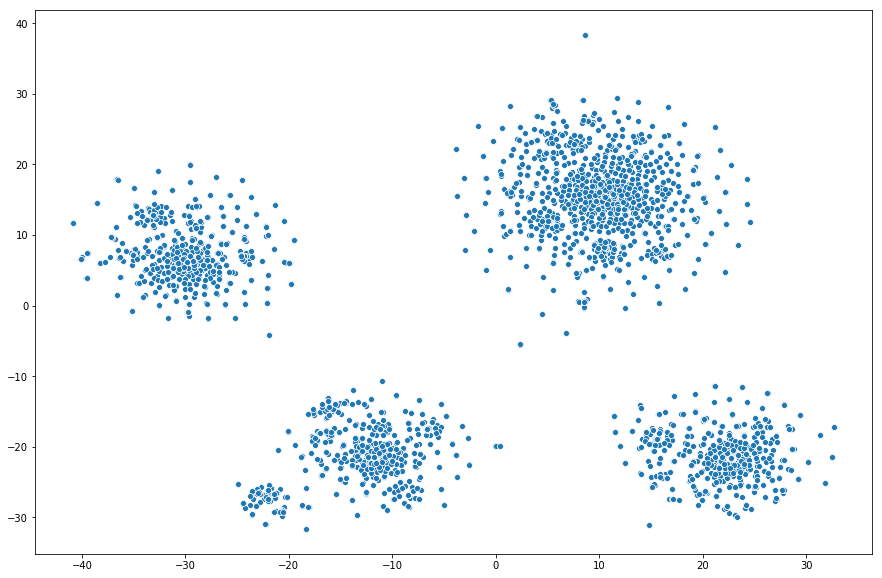

In [101]:
c_map = y[::]
c_map[c_map == 'positive'] = 'blue'
c_map[c_map == 'neutral'] = 'green'
c_map[c_map == 'negative'] = 'red'

plt.figure(figsize=(15, 10))
sns.scatterplot(
    X_embedded[:, 0],
    X_embedded[:, 1],
#     alpha=0.6,
#     c=c_map,
);